## Problem 1: RAG Agent

In [1]:
# Importing Necessary Libraries
import os
import requests
import zipfile
import sqlite3
import operator
import pandas as pd

from typing import TypedDict, Annotated, List
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_ollama.chat_models import ChatOllama
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

Defining Necessary variables and links

In [2]:
# --- Configuration ---
DATA_DIR = "Data"
DATA_FILE = os.path.join(DATA_DIR, "HR_Policy.txt")
VECTORSTORE_DIR = "hr_policy_vectorstore"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 150

In [3]:
def load_and_chunk_documents():
    """
    Loads the HR policy data from the TXT file and splits it into smaller chunks.
    """
    print("\n--- Step 1: Loading and Chunking Documents ---")
    # UPDATED: Check for the .txt file.
    if not os.path.exists(DATA_FILE):
        print(f"Error: {DATA_FILE} not found. Please ensure the dataset is downloaded.")
        return None

    # Reading the text file
    with open(DATA_FILE, 'r', encoding='utf-8') as f:
        full_text = f.read()
    
    # The text splitter works on a list of documents. We treat the whole file as one document.
    documents = [full_text]
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP
    )
    
    chunks = text_splitter.create_documents(documents)
    print(f"Created {len(chunks)} document chunks from the text file.")
    return chunks

In [4]:
def create_and_store_embeddings(chunks):
    """
    Creates embeddings for the document chunks and stores them in a Chroma vector store.
    """
    print("\n--- Step 2: Creating and Storing Embeddings ---")
    if not chunks:
        print("No chunks to process. Aborting.")
        return

    # Initialize the embedding model from HuggingFace
    print(f"Loading embedding model: '{EMBEDDING_MODEL}'...")
    embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)

    # Create the Chroma vector store
    # This will process all chunks and store their vector representations.
    # It will be persisted to disk in the VECTORSTORE_DIR.
    print(f"Creating vector store in '{VECTORSTORE_DIR}'...")
    Chroma.from_documents(
        chunks,
        embeddings,
        persist_directory=VECTORSTORE_DIR
    )
    print("Vector store created and persisted successfully.")


In [5]:
# Manually download the dataset first as per the instructions in the function.
doc_chunks = load_and_chunk_documents()
if doc_chunks:
    create_and_store_embeddings(doc_chunks)
print("\n--- Data Ingestion Complete ---")
print(f"Vector store is ready in the '{VECTORSTORE_DIR}' directory.")


--- Step 1: Loading and Chunking Documents ---
Created 25 document chunks from the text file.

--- Step 2: Creating and Storing Embeddings ---
Loading embedding model: 'all-MiniLM-L6-v2'...


/tmp/ipykernel_35873/200756242.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
/home/sushobhon/agentic-ai-workshop/agent_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating vector store in 'hr_policy_vectorstore'...
Vector store created and persisted successfully.

--- Data Ingestion Complete ---
Vector store is ready in the 'hr_policy_vectorstore' directory.


In [ ]:
# --- Configuration ---
VECTORSTORE_DIR = "hr_policy_vectorstore"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
OLLAMA_MODEL = "mistral:latest" # Make sure this model is pulled in Ollama

In [7]:
# --- 1. RAG Tool Definition ---
# Initialize embeddings and vector store once to be used by the tool
print("Loading embeddings and vector store for RAG tool...")
embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
vectorstore = Chroma(persist_directory=VECTORSTORE_DIR, embedding_function=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3}) # Retrieve top 3 results

Loading embeddings and vector store for RAG tool...


/tmp/ipykernel_35873/1493662442.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory=VECTORSTORE_DIR, embedding_function=embeddings)


In [8]:
# Defining retrive data function
@tool
def retrieve_hr_policy_info(query: str) -> str:
    """
    Searches the HR policy vector database to find relevant information
    for a given user query. Use this to answer questions about HR policies,
    such as leave, benefits, code of conduct, etc.
    """
    print(f"\t--- Executing RAG Tool for query: '{query}' ---")
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the HR policy documents."
        
    # Format the results into a single string to be passed to the LLM
    context = "\n\n---\n\n".join([doc.page_content for doc in results])
    print("\t--- RAG Tool Finished ---")
    return f"Retrieved context: \n{context}"


In [9]:
# --- 2. Agent State and Graph Definition ---

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

In [10]:
# --- 3. Graph Nodes and Conditional Logic ---

def should_continue(state: AgentState) -> str:
    """
    Decides the next step. If the LLM made a tool call, route to the 'tools' node.
    Otherwise, end the process.
    """
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state: AgentState):
    """
    Calls the Ollama LLM. It will either respond directly or decide to use a tool.
    """
    messages = state['messages']
    # The final response generation should not use the tool-calling model
    # to avoid loops. We'll decide which model to use based on the flow.
    # If the last message was a tool result, we use the base model to synthesize an answer.
    if isinstance(messages[-1], ToolMessage):
        print("\t--- Synthesizing final answer from tool output ---")
        response = model.invoke(messages)
    else:
        # This is the first call, where the model can decide to use a tool.
        print("\t--- Agent is deciding next step (respond or use tool) ---")
        response = model_with_tools.invoke(messages)
        
    return {"messages": [response]}


In [11]:
print("--- HR Policy RAG Agent Initializing ---")
    
# Check if the vector store exists
if not os.path.exists(VECTORSTORE_DIR):
    print(f"Error: Vector store not found at '{VECTORSTORE_DIR}'")
    print("Please Create Vector store first.")
    exit()

# Define the tool(s) for the agent
tools = [retrieve_hr_policy_info]

# Initialize the Ollama model
model = ChatOllama(model=OLLAMA_MODEL)

# Bind the tool to the model
model_with_tools = model.bind_tools(tools)

# Define the LangGraph workflow
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        END: END
    }
)
workflow.add_edge("tools", "agent")

# Compile the graph
app = workflow.compile()


--- HR Policy RAG Agent Initializing ---


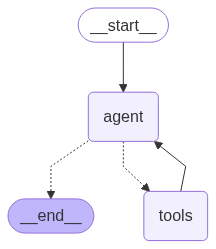

In [12]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
print("\n--- Starting HR Policy Assistant ---")
print("Type 'exit' to end the conversation.")

while True:
    user_input = input("\nYour question: ")
    print("---- #### ----")   
    if user_input.lower() == 'exit':
        break
    
    inputs = {"messages": [HumanMessage(content=user_input)]}
    
    # Stream the intermediate steps to see the agent's reasoning
    for output in app.stream(inputs):
        for key, value in output.items():
            print(f"\n\t--- Output from node '{key}':")
            # Print the message content for clarity
            if 'messages' in value:
                for msg in value['messages']:
                    if hasattr(msg, "tool_calls") and msg.tool_calls:
                        print(f"\tTool Call: {msg.tool_calls}")
            else:
                print(value)
        print("\n")
    
    # The final answer is the last message from the 'agent' node
    final_response = app.invoke(inputs)
    print("---- #### ----")
    print("Final Answer:", final_response['messages'][-1].content)
    print("---- #### ----\n\n")


--- Starting HR Policy Assistant ---
Type 'exit' to end the conversation.



Your question:  What was my previous question?


---- #### ----
	--- Agent is deciding next step (respond or use tool) ---

	--- Output from node 'agent':
	Tool Call: [{'name': 'retrieve_hr_policy_info', 'args': {'query': 'HR policy for taking time off during the holiday season'}, 'id': 'a1daaa7a-e2d6-4048-a16c-3d29f79148df', 'type': 'tool_call'}]


	--- Executing RAG Tool for query: 'HR policy for taking time off during the holiday season' ---
	--- RAG Tool Finished ---

	--- Output from node 'tools':


	--- Synthesizing final answer from tool output ---

	--- Output from node 'agent':


	--- Agent is deciding next step (respond or use tool) ---
	--- Executing RAG Tool for query: 'company's policy on taking time off during a pandemic' ---
	--- RAG Tool Finished ---
	--- Synthesizing final answer from tool output ---
---- #### ----
Final Answer:  The previous question was "What steps should I take if I need to take a leave of absence from work, such as for medical reasons or personal circumstances?" and the corresponding answer provi


Your question:  What is the process for approval to request time off?


---- #### ----
	--- Agent is deciding next step (respond or use tool) ---

	--- Output from node 'agent':
	Tool Call: [{'name': 'retrieve_hr_policy_info', 'args': {'query': 'What is the process for approval to request time off?'}, 'id': 'e6e21e01-98b1-4f83-8c99-2663c18ef81d', 'type': 'tool_call'}]


	--- Executing RAG Tool for query: 'What is the process for approval to request time off?' ---
	--- RAG Tool Finished ---

	--- Output from node 'tools':


	--- Synthesizing final answer from tool output ---

	--- Output from node 'agent':


	--- Agent is deciding next step (respond or use tool) ---
	--- Executing RAG Tool for query: 'What is the process for approval to request time off?' ---
	--- RAG Tool Finished ---
	--- Synthesizing final answer from tool output ---
---- #### ----
Final Answer:  Based on the provided context, here's a summary of the process for requesting time off:

1. Employees should follow the designated process outlined in their employee handbook.
2. Typically, this


Your question:  exit


---- #### ----


## Problem 2: Python Coding Agent

In [20]:
# Importing required libraries
import re, os
import operator
import subprocess
import sys
import sqlite3
from typing import TypedDict, Annotated, List

from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama.chat_models import ChatOllama
from langgraph.graph import StateGraph, END

In [2]:
# --- Configuration ---
OLLAMA_MODEL = "mistral:latest" # Make sure this model is pulled in Ollama
DB_FILE = "code_agent_memory.db" # New database file for this agent

In [3]:
# --- 1. Memory Management (SQLite) ---

def setup_database():
    """Initializes the SQLite database and creates the memory table if it doesn't exist."""
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS code_memory (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        role TEXT NOT NULL,
        content TEXT NOT NULL
    )
    """)
    conn.commit()
    conn.close()

In [4]:
def save_message(message: BaseMessage):
    """Saves a single message (Human or AI) to the database."""
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    role = 'unknown'
    if isinstance(message, HumanMessage):
        role = 'human'
    elif isinstance(message, AIMessage):
        role = 'ai'
    
    if role != 'unknown':
        cursor.execute("INSERT INTO code_memory (role, content) VALUES (?, ?)", (role, message.content))
        conn.commit()
    conn.close()

In [5]:
def load_messages() -> List[BaseMessage]:
    """Loads all past messages from the database to reconstruct the conversation history."""
    if not os.path.exists(DB_FILE):
        return []
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute("SELECT role, content FROM code_memory ORDER BY id ASC")
    rows = cursor.fetchall()
    conn.close()
    
    messages = []
    for role, content in rows:
        if role == 'human':
            messages.append(HumanMessage(content=content))
        elif role == 'ai':
            messages.append(AIMessage(content=content))
    return messages

In [6]:
# --- 2. Tool Definition for Code Execution ---
# This tool simulates our "Executor Agent". It takes Python code as input,
# executes it in a separate process, and returns the output or any errors.

def execute_python_code(code: str) -> str:
    """
    Executes a given string of Python code in a separate process.
    It captures and returns the standard output and standard error.
    """
    print("\t---EXECUTOR AGENT: Attempting to execute code.---")
    print("\tCODE:\n--- ### ---")
    print(code)
    print("--- ### ---")
    try:
        # Using subprocess to safely execute the code in a new python interpreter
        result = subprocess.run(
            [sys.executable, "-c", code],
            capture_output=True,
            text=True,
            check=True, # This will raise CalledProcessError if the command returns a non-zero exit code
            timeout=30 # Add a timeout for safety
        )
        output = result.stdout
        print(f"\t---EXECUTOR AGENT: Execution successful.---\n--- ### ---")
        print(f"OUTPUT:\n{output}")
        print("--- ### ---")
        return f"Execution successful. Output:\n{output}"

    except subprocess.CalledProcessError as e:
        # This catches errors from within the executed script (e.g., Python syntax errors)
        error_message = f"Execution failed with error:\n{e.stderr}"
        print(f"\t---EXECUTOR AGENT: Execution failed.---\n--- ### ---")
        print(error_message)
        print("--- ### ---")
        return error_message
    except subprocess.TimeoutExpired:
        error_message = "Execution failed: The code took too long to run (timeout)."
        print(f"\t---EXECUTOR AGENT: {error_message} ---")
        return error_message
    except Exception as e:
        # Catch other potential errors during subprocess setup
        error_message = f"An unexpected error occurred during execution: {e}"
        print(f"\t---EXECUTOR AGENT: {error_message} ---")
        return error_message

In [7]:
# --- 3. Agent State Definition ---
# This state will be passed between the nodes of our graph.

class AgentState(TypedDict):
    task: str
    code: str
    result: str
    messages: Annotated[List[BaseMessage], operator.add]


In [8]:
# --- 4. Agent and Node Definitions ---

# This is our "Generator Agent". It's an LLM prompted to be a Python programmer.
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a senior Python programmer. Your task is to write a complete, single Python script to solve the user's request.
                The script must be executable and should print the final answer(s) to the standard output.
                Do not use any imports that are not part of the standard Python library.
                If you are given an error message, you must analyze the previous code and the error, then generate a new, corrected version of the script.
                Your response must ONLY contain the Python code inside a single block. DO NOT add any preamble or any kind of text.
            """,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatOllama(model=OLLAMA_MODEL, temperature=0)
code_generator_agent = code_gen_prompt | llm


In [9]:

def extract_python_code(text):
    """
    Extracts Python code blocks from text using regex.

    Args:
        text (str): The input text containing code blocks.

    Returns:
        list of str: A list of extracted Python code blocks.
    """
    # Regular expression pattern to match ```python ... ```
    pattern = r"```python\s*(.*?)\s*```"
    # Use re.DOTALL to allow newlines inside code blocks
    code_blocks = re.findall(pattern, text, re.DOTALL)
    return code_blocks[0]


In [10]:
def generator_node(state: AgentState):
    """
    This node invokes the code generator agent to write or correct the Python code.
    """
    print("\t---GENERATOR AGENT: Thinking...")
    # The message history provides context, including the original task and any previous errors.
    response = code_generator_agent.invoke({"messages": state["messages"]})
    save_message(response) # Save the AI's response to memory
    
    # Extract the code from the AIMessage, cleaning up markdown fences
    code = extract_python_code(response.content)
    
    print("\t---GENERATOR AGENT: Generated new code.---")
    return {"code": code.strip()}

In [11]:
def executor_node(state: AgentState):
    """
    This node calls our code execution tool to run the generated code.
    """
    result = execute_python_code(state["code"])
    return {"result": result}

In [16]:
def conditional_router(state: AgentState):
    """
    This is the core logic. It checks the execution result and decides where to go next.
    """
    print("---ROUTER: Analyzing execution results...---")
    if "Execution failed" in state["result"]:
        print("---ROUTER: Execution failed. Routing back to Generator Agent for correction.---")
        # Add a message to the history to inform the generator of the error
        error_content = f"""The previous code you wrote failed.
                
                            ### PREVIOUS CODE:
                            {state['code']}

                            ### EXECUTION ERROR:
                            {state['result']}

                            Please analyze the error and provide a corrected version of the full script."""
        error_message = HumanMessage(content=error_content)
        save_message(error_message) # Save the corrective prompt to memory
        return {"messages": [error_message]}
    else:
        print("---ROUTER: Execution successful. Ending workflow.---")
        return END

In [17]:
# --- 5. Graph Definition and Execution ---

# Define the graph
workflow = StateGraph(AgentState)

# Add the nodes
workflow.add_node("generator", generator_node)
workflow.add_node("executor", executor_node)

# Set the entry point
workflow.set_entry_point("generator")

# Add the edges
workflow.add_edge("generator", "executor")
# The conditional edge decides the next step after execution
workflow.add_conditional_edges(
    "executor",
    conditional_router,
    {
        "generator": "generator", # If failed, go back to the generator
        END: END                  # If successful, end
    },
)

# Compile the graph into a runnable app
app = workflow.compile()

# Setup the database for persistent memory
setup_database()

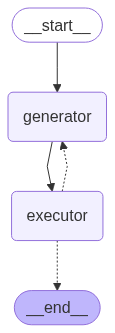

In [18]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
# --- Run the agent with the sample input ---
print("### Starting Code Generation Task ---\nType 'exit' to end the conversation.")
while True:
    user_input = input("\nYour request: ")
    if user_input.lower() == 'exit':
        break
    
    # Load conversation history and add the new user request
    messages = load_messages()
    new_user_message = HumanMessage(content=user_input)
    save_message(new_user_message) # Save the new request to memory
    messages.append(new_user_message)

    # The initial state for the graph
    initial_state = {
        "task": user_input,
        "messages": messages,
    }
    
    # Invoke the app. It will run until it succeeds or you interrupt it.
    final_state = app.invoke(initial_state)

    print("--- ### ---")
    print("--- Task Finished ---\n--- ### ---")
    print("Final Code:\n--- ### ---")
    print(final_state['code'])
    print("\n--- ### ---\n Final Result:\n--- ### ---")
    print(final_state['result'])
    print("--- ### ---")


	--- Starting Code Generation Task ---
Type 'exit' to end the conversation.
	---GENERATOR AGENT: Thinking...
	---GENERATOR AGENT: Generated new code.---
	---EXECUTOR AGENT: Attempting to execute code.---
	CODE:
--- ### ---
def is_perfect(n):
    sum = 0
    for i in range(1, n):
        if n % i == 0:
            sum += i
    return sum == n

def find_smallest_perfect():
    smallest = None
    for num in range(1, 32000):
        if is_perfect(num):
            if smallest is None or smallest > num:
                smallest = num
    return smallest

def prime_factors(n):
    factors = []
    i = 2
    while i * i <= n:
        if n % i == 0:
            n //= i
            factors.append(i)
        else:
            i += 1
    if n > 1:
        factors.append(n)
    return factors

def main():
    number = 100
    print("Prime factors of", number, "are:", prime_factors(number))
    smallest_perfect = find_smallest_perfect()
    print("Smallest perfect number is:", smallest_perfect)

